In [1]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import os
import time
from copy import deepcopy
from model.SiameseReId import SiameseReId
import matplotlib.pyplot as plt

/home/riccardo/anaconda3/envs/siv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YOLO("yolov8n-seg.pt") # COCO128 classes https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
# model = YOLO("yolov8n-seg.pt")
siamese_net = SiameseReId(os.path.join('model','weights','model_final.pt'))

In [3]:
file_path = 'test_scout.mp4'
cap = cv2.VideoCapture(file_path)
video_out = cv2.VideoWriter("./out.mp4", cv2.VideoWriter_fourcc(*'DIVX'), int(cap.get(cv2.CAP_PROP_FPS)), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [4]:
def crop_segmentation(segment,box,image):
    img = image.copy()
    box = box.astype(int)
    w,h,c = img.shape
    mask = (cv2.resize(segment,(h,w)) > 0).astype("uint8")
    img_segm = cv2.bitwise_and(img,img,mask=mask)
    img_segm = img_segm[box[1]:box[3],box[0]:box[2]]
    return cv2.cvtColor(img_segm, cv2.COLOR_BGR2RGB)

In [5]:
read = cap.read()

In [6]:
frame = read[1]
frame_copy = deepcopy(frame)

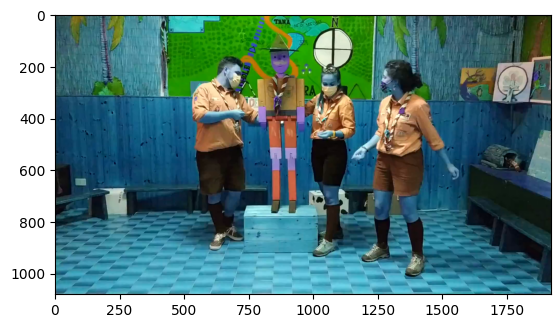

In [7]:
plt.imshow(frame)

In [8]:
results = model.predict(frame)[0]

Ultralytics YOLOv8.0.24 🚀 Python-3.9.16 torch-1.13.1+cu117 CPU
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

0: 384x640 3 persons, 433.0ms
Speed: 12.8ms pre-process, 433.0ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
masks = results.masks.masks.numpy()
boxes = results.boxes.xyxy.numpy()

In [10]:
cropped = [crop_segmentation(i[0],i[1],frame_copy) for i in zip(masks,boxes)]

In [12]:
len(cropped)

3

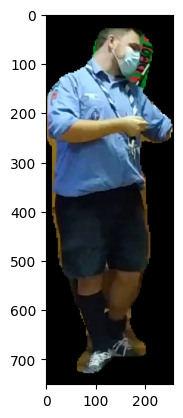

In [11]:
plt.imshow(cropped[0])

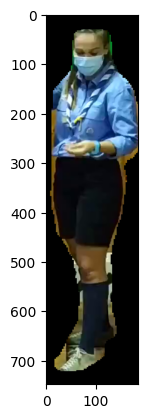

In [13]:
plt.imshow(cropped[1])

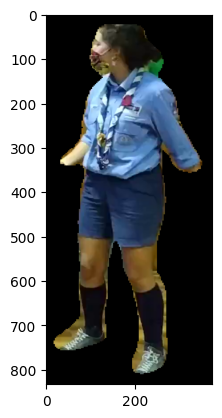

In [14]:
plt.imshow(cropped[2])

In [15]:
bosco = Image.fromarray(cropped[0])
bosco_fv = siamese_net.fv_encoding(bosco)

maria = Image.fromarray(cropped[1])
maria_fv = siamese_net.fv_encoding(maria)

In [16]:
siamese_net.similarity(bosco,maria_fv)

tensor([[0.99019]], grad_fn=<SigmoidBackward0>)